<a href="https://www.kaggle.com/code/mariuszcha/credit-card-fradulent-detection?scriptVersionId=128462844" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.preprocessing import RobustScaler

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


At first glance, our problem may appear to be straightforward, but we must bear in mind that we are dealing with sensitive bank data, and our objective is to detect fraudulent transactions. It is safe to assume that the distribution of transactions between the legitimate and fraudulent ones will likely be imbalanced.

Therefore, we intend to use a decision tree classification model to examine the transaction scores. It is imperative that we carefully assess the data and employ advanced statistical techniques to ensure that our model is robust and accurate in detecting fraudulent transactions.

In [2]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_palette('flare')
data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
display(data.head())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**Let's check dependant variable distribution...**

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

0    284315
1       492
Name: Class, dtype: int64

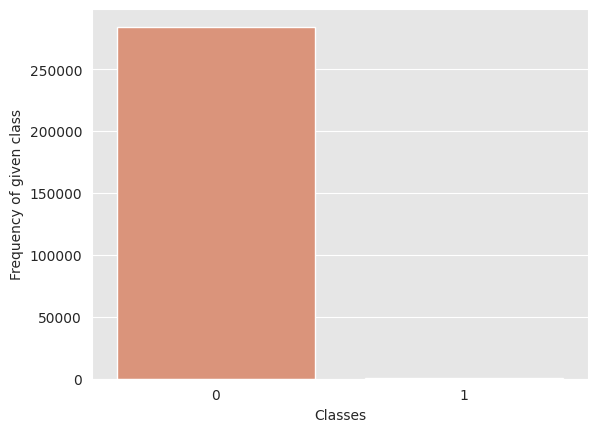

In [3]:
ax = sns.countplot(x=data.Class)
ax.set(xlabel='Classes', ylabel='Frequency of given class')

# Checking whether there are null values
display(data.isna().any())

# Checking number of classes in response variable and frequency
display(data.Class.value_counts())

As we can notice - the data is very unbalanced. We hardly see box for fradulent transactions. Fitting decision tree - or any classification model to data like that will probably produce us a quite good accuracy. BUT accuracy doesn't tell us everyting.
We could have high accuracy and model will predict perfectly non-fradulent transactions but it is not going to catch fradulent one. The number of False Negatives will be high (Type II Error) - and that basically means we will have low Recall. Recall will be our main indicator in evaluating the model. We will use F1-score too.

In dealing with unbalanced data like that - there are many things that we can do:
- Collect more data in order to balance Class columns (in that situation it is impossible because we are working with past data)
- Use Oversampling or Undersampling(Basically we balance data reducing the number of dominant-class records to have 50/50 OR we bootstrap our dataset to have more minor-class records - basically we copy minor-class records.)

We should also standarize our data. Decision Tree doesn't require that but maybe in the future I will try different models like Logistic Regression which require that. We should use StandardScaler as an our scaler BUT in that situation - in the describion of our dataset we can find that our features are basically PCA components. It is recommened to scale data BEFORE PCA - so we can assume our data is already Scaled. We should scale Time and Amount columns on the other hand. 

We also checked whether there are any NULL values and the answer is negative. 

**Firstly we will focus ond scaling data. Distributions are great to check how skewed is our data...**

[Text(0.5, 0, 'Time feature distribution')]

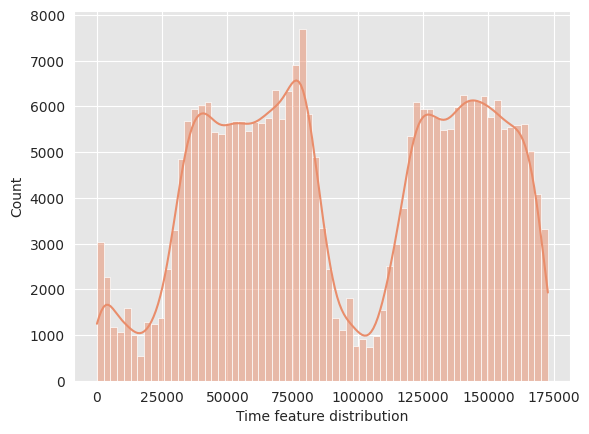

In [4]:
# Scaling Time and Amount

time = sns.histplot(data.Time, kde=True)
time.set(xlabel='Time feature distribution')

(0.0, 6600.0)

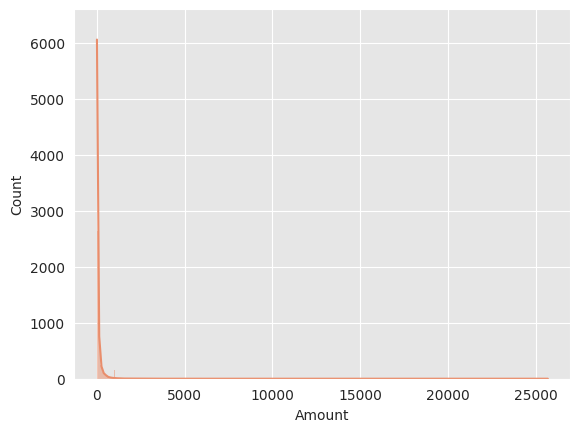

In [5]:
amount = sns.histplot(data.Amount, kde=True)
amount.set_ylim([0,6600])

As we can see - data is skewed - both amount and time. On Amount column, we can expect that there are outliers. We are going to scale both features using RobustScaler which is just better version of StandarScaler. It is basically robust to outliers which in many situations can be killers for our model.

In [6]:
Scaler = RobustScaler()
data['Time'] = Scaler.fit_transform(data['Time'].values.reshape(-1,1))
#data.drop('Time', axis=1, inplace=True)
data['Amount'] = Scaler.transform(data['Amount'].values.reshape(-1,1))

data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,0.118914,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,-0.993946,0.001727
std,0.557903,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,0.002938,0.041527
min,-0.994983,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,-0.994983,0.000000
25%,-0.358210,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,-0.994918,0.000000
50%,0.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,-0.994725,0.000000
75%,0.641790,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,-0.994077,0.000000
max,1.035022,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,-0.693157,1.000000


As we can see - Time and Amount are scaled. Their mean and std are smaller.

**Let's - now - test how our model will perform without any Undersampling and Oversampling. Just raw data. That will be our benchmark whether model improved or not.**

In [7]:
y = data['Class']
X = data.iloc[:,:-1]

def LRmodelKFold(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=13)
    acc_scores, f1_scores, recall_scores = [], [], []

    for train_index, test_index in kf.split(X):
        X_tr, X_te = X.iloc[train_index], X.iloc[test_index]
        y_tr, y_te = y.iloc[train_index], y.iloc[test_index]

        #model = LogisticRegression(max_iter=1000)
        model = DecisionTreeClassifier()
        model.fit(X_tr, y_tr)

        # Model Evaluation
        y_pred = model.predict(X_te)
        acc_scores.append(model.score(X_te, y_te))
        f1_scores.append(f1_score(y_te, y_pred))
        cm = confusion_matrix(y_te, y_pred, labels=[1,0])
        recall_scores.append(cm[0][0] / (cm[0][0] + cm[1][0]))
        print(cm)

    print('Accuracy:', np.mean(acc_scores))
    print('F1-Score:', np.mean(f1_scores))
    print('Recall:', np.mean(recall_scores))
    return model

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, test_size=0.2)
m = LRmodelKFold(X_train, y_train)

print('F1-Score for previously unseen data:', f1_score(m.predict(X_test),y_test))

[[   59    25]
 [   18 45467]]
[[   64    27]
 [   25 45453]]
[[   56    16]
 [   16 45481]]
[[   64    21]
 [   27 45457]]
[[   56    14]
 [   25 45474]]
Accuracy: 0.9990607649937457
F1-Score: 0.7381605450249273
Recall: 0.7315534791190222
F1-Score for previously unseen data: 0.7395833333333334


As we can see - accuracy for our model is nearly 100% but it's not even close to correct model. F1-score which is harmonic mean between Precision and Recall is about 72%

Our model classified correctly about 50 fradulent transaction(True Positive) per fold,
it classified also correctly over 45000 correct transactions(True Negative) per fold.
It classified over 20 correct transactions as fradulent one(False Positive), but the worst thing is number of False Negative. about 10(and in one situation 50) fradulent transactions were classified as normal one! That's called Type II Error.

Now we will do everything to improve recall of our model. 73% doesn't look that terrible in terms of accuracy but we need recall as high as possible. Any 1% can be milions of dollars in banking or life of a person(if we predicting whether cancer is beign or not)

We have to remember about Precision/Recall trade-off. Increase in one of the indicator often means decrease in the other one. In that problem very high Recall is what we want. We - as a bank - prefer to detect a Correct transaction as fradulent one and then check it manually than classify Fradulent one as corrent. This is definitely worse in consequences

**Now we will the RandomUnderSampler and RandomOverSampler - then we will choose which one deals better with our unbalance.**

In [8]:
# Using RandomUnderSampler
UnderResampler = RandomUnderSampler(random_state=13)
Xur, yur = UnderResampler.fit_resample(X, y)

X_train_ur, X_test_ur, y_train_ur, y_test_ur = train_test_split(Xur, yur, random_state=13, test_size=0.2)
URmodel = LRmodelKFold(X_train_ur, y_train_ur)
print('F1-Score for previously unseen data:', f1_score(URmodel.predict(X_test_ur),y_test_ur))


[[69  3]
 [14 72]]
[[73  9]
 [ 7 69]]
[[65 11]
 [ 8 73]]
[[76  4]
 [ 7 70]]
[[74  2]
 [ 3 78]]
Accuracy: 0.9136418608401193
F1-Score: 0.9127751937768254
Recall: 0.9021875743500598
F1-Score for previously unseen data: 0.9326923076923077


As we can notice - Recall and F1 increased a lot for RandomUnderSampler. Now we will do the same thing for RandomOverSampler

In [9]:
# Using RandomOverSampler
OverResampler = RandomOverSampler(random_state=13)
Xor, yor = OverResampler.fit_resample(X, y)

X_train_or, X_test_or, y_train_or, y_test_or = train_test_split(Xor, yor, random_state=13, test_size=0.2,)
ORmodel = LRmodelKFold(X_train_or, y_train_or)
print('F1-Score for previously unseen data:', f1_score(ORmodel.predict(X_test_or),y_test_or))

[[45535     0]
 [   25 45421]]
[[45605     0]
 [   25 45351]]
[[45739     0]
 [   29 45213]]
[[45402     0]
 [   25 45554]]
[[45190     0]
 [   33 45757]]
Accuracy: 0.9996988374216219
F1-Score: 0.9996988787372179
Recall: 0.9993979413435335
F1-Score for previously unseen data: 0.9997625643055006


As we can see - both methods works quite well. We are going to stay with RandomOverSampler. It performs better on totally unseen data. Another important thing is hyperparameter tuning which could improve the Recall and F1 little bit - for now-  i'm satisfied with already obtained score.

We will also test our ORmodel which is trained on oversampled data on testdata which is not sampled.  As we can notice below F1-Score for dataset is nearly 94% and Recall is 88%. That's a comfortable outcome. Our model will be definitely helpful for banks!

In [10]:
print('F1-Score for unseen, not resampled data:', f1_score(ORmodel.predict(X_test),y_test))
print('Recall for unseen, not resampled data:', recall_score(ORmodel.predict(X_test),y_test))

F1-Score for unseen, not resampled data: 0.9473684210526316
Recall for unseen, not resampled data: 0.9
